In [48]:
## In this notebook the Social Force Model is coded as described in our source paper Helbing et al. (2000)
# Scope of this notebook is a baseline escape simulation

In [75]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib inline


In [123]:
#parameters.py 

#Physical Parameters from Helbing et al. 2000)

mass = 80.0                # kg
tau = 0.5                  # relaxation time (s)
a = 2000.0                # social force strength (N)
b = 0.08                   # social force range (m)

#The paper introduces a body compression (repulsive) force that prevents pedestrians from occupying the same space
#There is a body compression when people are pressed against each other
k_body = 1.2e5             # body force constant 

#This variable introduces a tangential friction between bodies when they touch: prevents people
#sliding past each other easily
k_friction = 2.4e5         # sliding friction constant

# Desired speed
v_desired = 1.5            # m/s (baseline, non-panic)

# Geometry
pedestrian_radius_range = (0.25, 0.35)  # meters

# Time stepping
dt = 0.01
total_time = 60

In [124]:
#pedestrian.py
#Pedestrian Class 

class Pedestrian:
    def __init__(self, position, velocity, desired_direction, radius):
        self.position = position
        self.velocity = velocity
        self.desired_direction = desired_direction
        self.radius = radius
        self.exited = False

In [125]:
#environment.py
# Room Class for geometry and exits

ROOM_WIDTH = 15
ROOM_HEIGHT = 15

EXIT_X = 15.0
EXIT_Y_MIN = 6.5
EXIT_Y_MAX = 8.5

In [126]:
#forces.py
#Computation of the forces

#At each timestep, each pedestrian experiences three types of forces
#1) Desired force: Desired direction + desired speed that give the driving force of the pedestrian
#2) Pedestrian interaction forces: social repulsion (personal space) to avoid collision and
    #physical contact forces: only active when pedestrians touch (compression and sliding)

#3) Pedestrian - wall interaction force: mathematically similar to (2)

#Desired Force
def desired_force(ped):
    return (v_desired * ped.desired_direction - ped.velocity) / tau

#Pedestrian interactions
def pedestrian_force(p_i, p_j):

    # Create a distance vector between pedestrians
    r_ij = p_i.position - p_j.position
    d_ij = np.linalg.norm(r_ij)

    if d_ij == 0:
      return np.zeros(2)

    n_ij = r_ij / d_ij

    overlap = p_i.radius + p_j.radius - d_ij

    # Social repulsion (always active)
    force = a * np.exp(overlap / b) * n_ij

    if overlap > 0:
        # Body force
        force += k_body * overlap * n_ij

        # Sliding friction
        t_ij = np.array([-n_ij[1], n_ij[0]])
        delta_v = np.dot(p_j.velocity - p_i.velocity, t_ij)
        force += k_friction * overlap * delta_v * t_ij

    return force

#Wall Force    
def wall_force(ped):
    force = np.zeros(2)

    # --- Left wall (x = 0)
    d = ped.position[0] - ped.radius
    if d < 0:
        n = np.array([1.0, 0.0])
        force += a * np.exp(-d / b) * n
        force += k_body * (-d) * n
        force -= k_friction * (-d) * ped.velocity

    # --- Right wall (x = ROOM_WIDTH), except exit
    if not (EXIT_Y_MIN <= ped.position[1] <= EXIT_Y_MAX):
        d = ROOM_WIDTH - ped.position[0] - ped.radius
        if d < 0:
            n = np.array([-1.0, 0.0])
            force += a * np.exp(-d / b) * n
            force += k_body * (-d) * n
            force -= k_friction * (-d) * ped.velocity

    # --- Bottom wall (y = 0)
    d = ped.position[1] - ped.radius
    if d < 0:
        n = np.array([0.0, 1.0])
        force += a * np.exp(-d / b) * n
        force += k_body * (-d) * n
        force -= k_friction * (-d) * ped.velocity

    # --- Top wall (y = ROOM_HEIGHT)
    d = ROOM_HEIGHT - ped.position[1] - ped.radius
    if d < 0:
        n = np.array([0.0, -1.0])
        force += a * np.exp(-d / b) * n
        force += k_body * (-d) * n
        force -= k_friction * (-d) * ped.velocity

    return force



In [127]:
def update_desired_direction(ped):
    exit_center = np.array([
        EXIT_X,
        0.5 * (EXIT_Y_MIN + EXIT_Y_MAX)
    ])

    direction = exit_center - ped.position
    norm = np.linalg.norm(direction)

    if norm > 1e-6:
        ped.desired_direction = direction / norm
    else:
        ped.desired_direction = np.array([1.0, 0.0])


In [128]:
#simulation.py
# Time integration loop that implements the equation from the paper

def step(pedestrians):

    forces = []

    for i, p_i in enumerate(pedestrians):
        if p_i.exited:
            forces.append(np.zeros(2))
            continue

        F = desired_force(p_i)

        for j, p_j in enumerate(pedestrians):
            if i != j and not p_j.exited:
                F += pedestrian_force(p_i, p_j)

        F += wall_force(p_i)


        forces.append(F)

    for p, F in zip(pedestrians, forces):
        if p.exited:
            continue

        acc = F / mass
        p.velocity += acc * dt
        p.position += p.velocity * dt


In [142]:
#metrics.py

def check_exit(ped, t):
    if (
        ped.position[0] >= EXIT_X
        and EXIT_Y_MIN <= ped.position[1] <= EXIT_Y_MAX
    ):
        ped.exited = True
        ped.exit_time = t




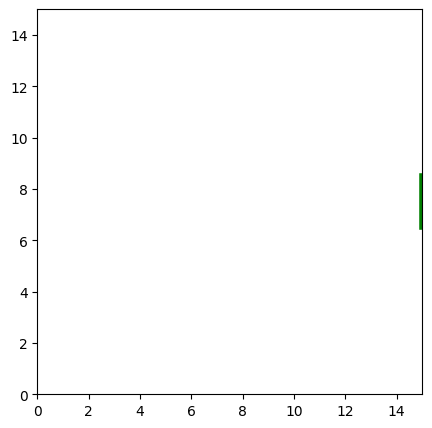

In [144]:
#Run Simulation Code
def initialize_pedestrians(N):
    pedestrians = []

    for _ in range(N):
        pos = np.array([
            np.random.uniform(0.5, ROOM_WIDTH - 0.5),
            np.random.uniform(0.5, ROOM_HEIGHT - 0.5)
        ])

        vel = np.zeros(2)

        direction = np.array([1.0, 0.0])  # towards exit
        radius = np.random.uniform(0.25, 0.35)

        pedestrians.append(
            Pedestrian(pos, vel, direction, radius)
        )

    return pedestrians


pedestrians = initialize_pedestrians(40)

times = np.arange(0, total_time, dt)

#PLOT
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, ROOM_WIDTH)
ax.set_ylim(0, ROOM_HEIGHT)
ax.set_aspect("equal")

# Draw exit
ax.plot([EXIT_X, EXIT_X], [EXIT_Y_MIN, EXIT_Y_MAX], color="green", linewidth=4)

scatter = ax.scatter(
    [], [],
    s=30,
    c="blue"
)


def init():
    scatter.set_offsets(np.empty((0, 2)))
    return scatter,

def update(frame):

    if frame < 10:
        print("Remaining:", sum(not p.exited for p in pedestrians))

    t = frame * dt

    #update desired direction
    for p in pedestrians:
        if not p.exited:
            update_desired_direction(p)

    #apply forces and move
    step(pedestrians)

    #check exit after movement
    for p in pedestrians:
        if not p.exited:
            check_exit(p, t)

    positions = np.array([
    p.position for p in pedestrians if not p.exited])

    if positions.shape[0] > 0:
        scatter.set_offsets(positions)
    else:
        scatter.set_offsets(np.empty((0, 2)))



    ax.set_title(f"t = {t:.2f}s, remaining = {sum(not p.exited for p in pedestrians)}")
    return scatter,


In [145]:
#Just as a check that the simulation is not empty
print("Number of pedestrians:", len(pedestrians))
print("First position:", pedestrians[0].position)


Number of pedestrians: 40
First position: [1.78326292 8.12067366]


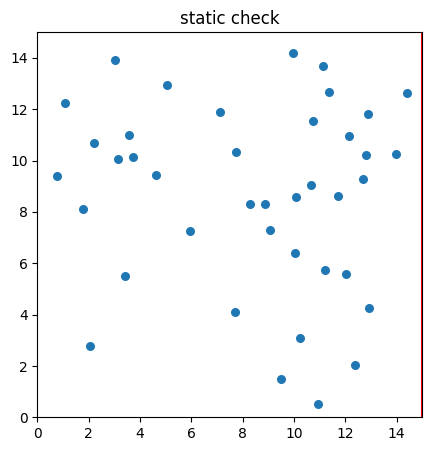

In [146]:
# added this because the animation does not work so a static check

xs = [p.position[0] for p in pedestrians]
ys = [p.position[1] for p in pedestrians]


plt.figure(figsize=(5,5))
plt.scatter(xs, ys, s=30)
plt.axvline(EXIT_X, color="red")
plt.xlim(0, ROOM_WIDTH)
plt.ylim(0, ROOM_HEIGHT)
plt.gca().set_aspect("equal")
plt.title("static check")
plt.show()


In [147]:
anim = FuncAnimation(
    fig,
    update,
    frames=200,
    init_func=init,
    interval=50,
    blit=True
)

from IPython.display import HTML
HTML(anim.to_jshtml())



Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
Remaining: 40
